<a href="https://colab.research.google.com/github/vasanthsai26/oxford-pet-localiztion-and-classification/blob/main/object_localization_and_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OxfordIIITPet Localization and Classification - PyTorch

---






**Problem Statement**

- Classify and Localize the Pets in the images



**Dataset**



> The Oxford-IIIT Pet Dataset





<img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" alt="object_localzation_segmentation" width="600" height="400">


- The Oxford Pets dataset (also known as the "dogs vs cats" dataset) is a collection of images and annotations labeling various breeds of dogs and cats. There are approximately 100 examples of each of the 37 breeds. This dataset contains the object detection portion of the original dataset with bounding boxes around the animals' heads.

> Evaluation Metric

**IOU (Intersection over Union)**

- IOU(Intersection over Union) is a term used to describe the extent of overlap of two boxes. The greater the region of overlap, the greater the IOU.
- It is used to evaluate the performance of object detection by comparing the ground truth bounding box to the preddicted bounding box
-  For example in the image below, we have a green box, and a red box. The green box represents the  ground truth box, and the red box represents the prediction from our model. The aim of this model would be to keep improving its prediction, until the red box and the green box perfectly overlap, i.e the IOU between the two boxes becomes equal to 1.


<img src="https://i.imgur.com/INoHzQF.jpg" alt="IOU_example" width="600" height="400">

- IOU is also used in non max suppression, which is used to eliminate multiple boxes that surround the same object, based on which box has a higher confidence.

<img src="https://i.imgur.com/NO8nAQx.png" alt="IOU_example" width="500" height="350">

## Data Gathering and Initial Insights

### Installing and Importing the required packages

In [ ]:
## Installing the libraries
!pip install -U git+https://github.com/albumentations-team/albumentations --q
!pip install --upgrade opencv-contrib-python --q
!pip install torchinfo --q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 12.9 MB/s eta 0:00:00


In [3]:
## General Imports
import random
import math
import os
import pickle 
import xml.etree.ElementTree as et

from PIL import Image 
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

## Data Analysis packages
import numpy as np
import pandas as pd

## Data Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

# We will be reading images using OpenCV
import cv2

## for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## torch imports
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary 
from torchvision import datasets

## Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2 

## sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

ModuleNotFoundError: ignored

### Project Configurations

In [ ]:
#DIR CONFIGS
ROOT_DIR = "/content"
IMAGE_DIR = "/content/data/oxford-iiit-pet/images"
ANNOT_DIR = "/content/data/oxford-iiit-pet/annotations" 

## DATA CONFIGS
IMG_SIZE = 224
IMAGE_CHANNELS = 3
NUM_CLASSES = 37
BOUNDING_BOX_POINTS = 4

## INITIAL TRANING CONFIGS
RESNET_LAYERS = 50 
SCALE = 1.1
SEED = 42
EPOCHS = 175 
BATCH_SIZE = 32
WT_DECAY = 1e-4
LR = 0.01
MOMENTUM = 0.90
GRAD_CLIP = 0.1
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
ONLY_BBOX = False

- General Helper Functions

In [ ]:
def seed_everything(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED  
    """
    random.seed(TORCH_SEED)  
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

### Downloading and Loading the Dataset

#### Downloading the data from torchvision datasets

In [ ]:
train_val_data = datasets.OxfordIIITPet(root="./data",
                                        split='trainval',
                                        download=True,
                                        target_types=["category","segmentation"])
test_data = datasets.OxfordIIITPet(root="./data",
                                   split='test',
                                   download=True,
                                   target_types=["category","segmentation"])

#### Data Preprocessing

In [ ]:
def get_data_dict():
    """
    Return data dict structure
    """
    data_dict = {
        "image_name" : list(),
        "image_path" : list(),
        "xmin": list(),
        "ymin": list(),
        "xmax": list(),
        "ymax": list(),
        "class_label": list(),
        "species_label": list() 
        }
    return data_dict

In [ ]:
def get_BB(xml_path):
    """
    Parse the XML file and the ground truth Bounding box coordinates
    """
    #parse the annotations
    tree = et.parse(xml_path)  # xml reading library (web scraping )
    root = tree.getroot()

    bbox = root.find("object/bndbox")

    xmin = bbox.find('xmin').text
    xmax = bbox.find('xmax').text

    ymin = bbox.find('ymin').text
    ymax = bbox.find('ymax').text

    return ((int(xmin),int(ymin)),(int(xmax),int(ymax)))

In [ ]:
def validate_file(file): # ('Abyssinian_100')
    """
    Return image path and XML file path if exist
    """
    img_file = file + ".jpg"
    xml_file = file + ".xml"

    img_path = os.path.join(IMAGE_DIR,img_file)
    xml_path = os.path.join(ANNOT_DIR,"xmls",xml_file)

    if os.path.isfile(img_path):
        if os.path.isfile(xml_path):
            return (img_path,xml_path)
        else:
            print(f"XML file for {img_file} is not available")
            return (img_path,None)

    print(f"Image file for {img_file} is not available")
    return (None,None)

In [ ]:
def add_data(img_path,xml_path,data_dict):
    """
    Add the data to the data_dict by parsing the img_path and xml_path
    """
    image = os.path.basename(img_path)
    data_dict["image_name"].append(image)
    data_dict["image_path"].append(img_path)

    (xmin,ymin),(xmax,ymax) = get_BB(xml_path)
    data_dict["xmin"].append(xmin)
    data_dict["ymin"].append(ymin)
    data_dict["xmax"].append(xmax)
    data_dict["ymax"].append(ymax)

    class_name = "_".join(image.split("_")[:-1])
    species_label = "Cat" if class_name[0].isupper() else "Dog"

    data_dict["class_label"].append(class_name.lower())
    data_dict["species_label"].append(species_label)  

In [ ]:
def get_data(image_path=IMAGE_DIR,
             annot_path=ANNOT_DIR,
             val_split = 0.2):
    """
    Read, Parse and return the train and validation 
    """

    with open(os.path.join(annot_path, "trainval.txt"),"r") as train_val_txt:
        ## read the train val file
        train_val_images = train_val_txt.readlines()
        
        data_dict = get_data_dict()

        for image in train_val_images:

            image = image.strip().split()  # space is default one
            img_path,xml_path = validate_file(image[0])

            if img_path and xml_path:
                add_data(img_path,xml_path,data_dict)

        # Prepare train and validation set
        data_df = pd.DataFrame(data_dict).sort_values(by="class_label")

        # Encode the class label
        encoder = LabelEncoder().fit(data_df["class_label"])
        data_df["class_idx"] = encoder.transform(data_df["class_label"])

        # make train and val split
        train_df, val_df = train_test_split(data_df, 
                                            test_size = val_split, 
                                            stratify=data_df['class_label'])
    return train_df,val_df

- loading the Data

In [ ]:
train_df,val_df = get_data()

XML file for Abyssinian_104.jpg is not available
XML file for Bengal_111.jpg is not available
XML file for samoyed_10.jpg is not available
XML file for Bengal_175.jpg is not available
XML file for Egyptian_Mau_14.jpg is not available
XML file for Egyptian_Mau_156.jpg is not available
XML file for Egyptian_Mau_186.jpg is not available
XML file for Ragdoll_199.jpg is not available
XML file for saint_bernard_15.jpg is not available


##Data Exploration

In [ ]:
train_df.head()

,image_name,image_path,xmin,ymin,xmax,ymax,class_label,species_label,class_idx
65,american_bulldog_115.jpg,/content/data/oxford-iiit-pet/images/american_...,182,49,298,173,american_bulldog,Dog,1
2034,basset_hound_183.jpg,/content/data/oxford-iiit-pet/images/basset_ho...,104,9,403,305,basset_hound,Dog,3
2548,german_shorthaired_164.jpg,/content/data/oxford-iiit-pet/images/german_sh...,60,48,457,398,german_shorthaired,Dog,14
2845,Maine_Coon_174.jpg,/content/data/oxford-iiit-pet/images/Maine_Coo...,145,37,257,165,maine_coon,Cat,20
2529,german_shorthaired_147.jpg,/content/data/oxford-iiit-pet/images/german_sh...,1,20,386,321,german_shorthaired,Dog,14


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2936 entries, 65 to 1055
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     2936 non-null   object
 1   image_path     2936 non-null   object
 2   xmin           2936 non-null   int64 
 3   ymin           2936 non-null   int64 
 4   xmax           2936 non-null   int64 
 5   ymax           2936 non-null   int64 
 6   class_label    2936 non-null   object
 7   species_label  2936 non-null   object
 8   class_idx      2936 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 229.4+ KB


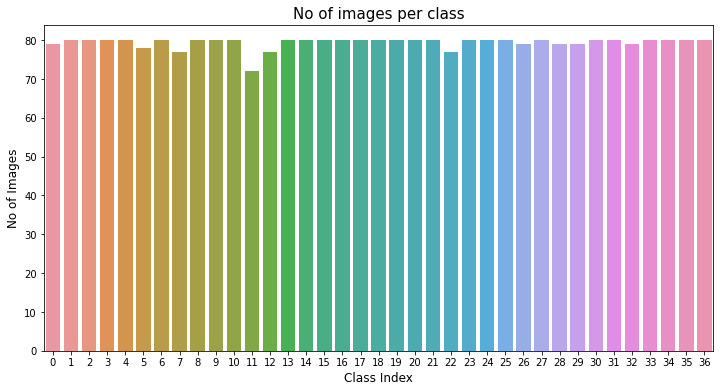

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x=train_df["class_idx"])
axes.set_xlabel("Class Index",fontsize="large")
axes.set_ylabel("No of Images",fontsize="large")
axes.set_title("No of images per class",fontsize=15)
fig.show();

- The Average no of images per class 80

In [ ]:
class_to_idx = train_df.groupby(by=["class_idx","class_label","species_label"]).size().to_frame().reset_index()
class_to_idx = class_to_idx.set_index("class_idx").loc[:,["class_label","species_label"]]

In [ ]:
class_to_idx.to_csv("idx_to_label.csv")
class_to_idx.to_json("idx_to_label.json")
class_to_idx = class_to_idx.to_dict()

In [ ]:
class_to_idx.keys()

Index(['class_label', 'species_label'], dtype='object')

In [ ]:
import json
with open("/content/idx_to_label.json","r") as json_file:
    idx_to_label = json.load(json_file)

In [ ]:
idx_to_label['class_label']['0'],idx_to_label['species_label']['0']

('abyssinian', 'Cat')

- Sample Images

In [ ]:
def show_image(idx,file,ax):
    img_path,xml_path = validate_file(file)

    if img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if xml_path:
        pt1, pt2 = get_BB(xml_path)
        img = cv2.rectangle(img, pt1, pt2, (0,255,0), 2)
    if img_path:
        breed = class_to_idx["class_label"][idx]
        species = class_to_idx["species_label"][idx]
        ax.set_title(f"Breed : {breed} | Species : {species}")
        ax.imshow(img)
        ax.set_axis_off()
    else:
        pass

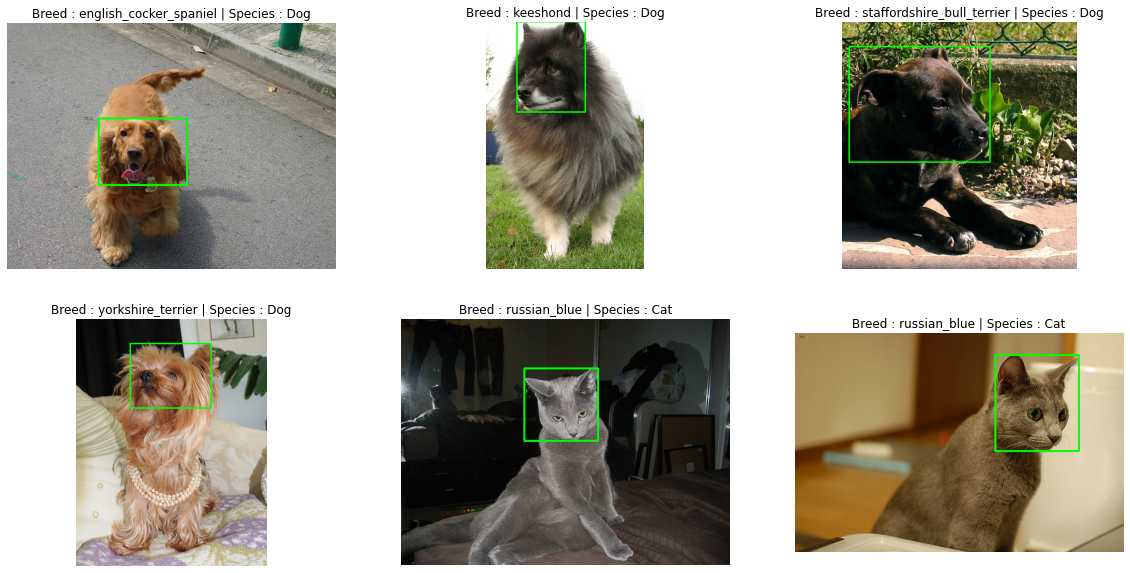

In [ ]:
fig,  axes = plt.subplots(2, 3, figsize=(20,10))
axes = [ax for sub_ax in axes for ax in sub_ax]
for idx in range(len(axes)):
  sample = train_df.sample(1)
  class_idx = int(sample["class_idx"].values)
  file = sample["image_name"].to_list()[0].split(".")[0]
  show_image(class_idx,file,axes[idx])

In [ ]:
val_df.head()

,image_name,image_path,xmin,ymin,xmax,ymax,class_label,species_label,class_idx
663,english_setter_118.jpg,/content/data/oxford-iiit-pet/images/english_s...,197,82,263,134,english_setter,Dog,13
387,Bombay_138.jpg,/content/data/oxford-iiit-pet/images/Bombay_13...,240,55,659,473,bombay,Cat,7
1574,shiba_inu_129.jpg,/content/data/oxford-iiit-pet/images/shiba_inu...,226,27,304,146,shiba_inu,Dog,31
2952,newfoundland_171.jpg,/content/data/oxford-iiit-pet/images/newfoundl...,151,1,401,302,newfoundland,Dog,22
2701,japanese_chin_167.jpg,/content/data/oxford-iiit-pet/images/japanese_...,210,52,367,177,japanese_chin,Dog,17


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 663 to 3481
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     735 non-null    object
 1   image_path     735 non-null    object
 2   xmin           735 non-null    int64 
 3   ymin           735 non-null    int64 
 4   xmax           735 non-null    int64 
 5   ymax           735 non-null    int64 
 6   class_label    735 non-null    object
 7   species_label  735 non-null    object
 8   class_idx      735 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 57.4+ KB


## Custom Dataset and Dataloader

### Albumentations

 - Albumentations is a Python library for image augmentation. Albumentations supports all common computer vision tasks such as classification, semantic segmentation, instance segmentation, object detection, and pose estimation.

In [ ]:
### Simple image augmenattions for train and val data
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMG_SIZE * SCALE)),
        A.PadIfNeeded(
            min_height=int(IMG_SIZE * SCALE),
            min_width=int(IMG_SIZE * SCALE),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)

In [ ]:
val_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMG_SIZE),
        A.PadIfNeeded(
            min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

In [ ]:
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMG_SIZE),
        A.PadIfNeeded(
            min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.CenterCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

- DeNormalize function

In [ ]:
def denormalize(images, means=IMAGENET_MEAN, stds=IMAGENET_STD,device=get_device()):
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)

### Custom Dataset

In [ ]:
class oxfordDataset(Dataset):
    def __init__(self,data_df,augmentations=None):
        self.data_df = data_df  ## train_df
        self.augmentations = augmentations ## train_transforms

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self,idx):
        img_details = self.data_df.iloc[idx]

        img_path = img_details["image_path"]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        class_label = torch.tensor(img_details["class_idx"], dtype=torch.long)
        xmin = img_details["xmin"]
        ymin = img_details["ymin"]
        xmax = img_details["xmax"]
        ymax = img_details["ymax"]

        bbox=[[xmin,ymin,xmax,ymax]]
        if self.augmentations:
            data = self.augmentations(image = image, bboxes = bbox, class_labels=[class_label])
            try: 
                image = data["image"]
                bboxes = torch.tensor(data["bboxes"][0], dtype=torch.float32)
                #class_label = data["class_labels"]
            except IndexError:
                print(img_path,idx)
                print(data)
        return (image.to(torch.float),class_label,bboxes)

In [ ]:
idx = ([3,224,224],1,[xmin,ymin,xmax,ymax])

### Dataloaders

In [ ]:
seed_everything(SEED)
train_data = oxfordDataset(train_df,train_transforms)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

- Test data

In [ ]:
val_df, test_df = train_test_split(val_df, 
                                   test_size = 0.3, 
                                   stratify=val_df['class_label'])

In [ ]:
seed_everything(SEED)
val_data = oxfordDataset(val_df,val_transforms)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE)

In [ ]:
seed_everything(SEED)
test_data = oxfordDataset(test_df,test_transforms)
test_dataloader = DataLoader(dataset=test_data, batch_size=8)

## Model LocNet(RESNET backbone)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,num_layers,in_channels,out_channels,identity_downsample=None,stride=1):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Not a Valid architecture'

        super(ResidualBlock,self).__init__()
        self.num_layers = num_layers
        self.expansion = 1 if self.num_layers < 50 else 4

        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                               kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        if self.num_layers >= 50:

            self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                                   kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels * self.expansion,
                                    kernel_size=1, stride=1, padding=0,bias=False)
            
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                   kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels * self.expansion,
                                    kernel_size=3, stride=1, padding=1,bias=False)
            
        
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.downsample = identity_downsample

    def forward(self,x): #[bs,filters,size,size]
        identity = x
        if self.num_layers >= 50:
            x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample is not None and self.num_layers >= 50:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '

        super(ResNet,self).__init__()

        self.expansion = 1 if num_layers < 50 else 4
        self.layers = self.get_layers(num_layers)

        ## num_out = ((num_in + 2*padding - kernal) / stride) + 1 
        ## conv1 layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=image_channels,out_channels=self.in_channels,
                               kernel_size=(7,7), stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, self.layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, self.layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, self.layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, self.layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * self.expansion, num_classes)
    
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        return x

    def make_layers(self,num_layers,block,num_residual_blocks,intermediate_channels,stride):
        layers = []
        downsample = None
        if num_layers >= 50: 
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, 
                                                      kernel_size=1, stride=stride,bias=False),
                                                    nn.BatchNorm2d(intermediate_channels*self.expansion))
        
        layers.append(block(num_layers, self.in_channels, intermediate_channels, downsample, stride))

        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def get_layers(self,num_layers):
        self.layer_map = {
            18 : [2, 2, 2, 2],
            34 : [3, 4, 6, 3],
            50 : [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3]
        }
        return self.layer_map.get(num_layers,None)

In [ ]:
class bboxRegressor(nn.Module):
    def __init__(self,in_features,bb_points,expansion):
        super(bboxRegressor,self).__init__()
        self.in_features = in_features
        self.bb_points = bb_points 
        self.expansion = expansion 
        self.intermediate_layers = 2048

        self.conv1 = nn.Conv2d(in_channels=self.in_features,out_channels=self.intermediate_layers,
                               kernel_size=(3,3), stride=1, padding=1,bias=False)
        self.conv2 = nn.Conv2d(in_channels=self.intermediate_layers,out_channels=self.intermediate_layers,
                               kernel_size=(3,3), stride=1, padding=1,bias=False)
        self.conv3 = nn.Conv2d(in_channels=self.intermediate_layers,out_channels=self.in_features,
                               kernel_size=(3,3), stride=1, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.intermediate_layers)
        self.bn2 = nn.BatchNorm2d(num_features=self.in_features)
    
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(
            nn.Conv2d(in_channels=self.in_features,out_channels=self.in_features,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(self.in_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)       
        )
        self.bbox_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.3,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=self.bb_points)
        )

    def forward(self,x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        for _ in range(self.expansion):
            x = self.relu(self.bn1(self.conv2(x)))
        x = self.relu(self.bn2(self.conv3(x)))
        x = self.maxpool(self.relu(x+identity))
        x = self.last_conv(x)
        x = self.bbox_layer(x)
        return x 

In [ ]:
class LocNet(nn.Module):
    def __init__(self,num_layers,image_channels,num_classes,bb_points,block,bboxblock,pretrained):
        super(LocNet,self).__init__()
        self.num_layers = num_layers
        self.image_channels = image_channels
        self.custom_resnet = block
        self.num_classes = num_classes
        self.bb_points = bb_points
        self.backbone= self.get_backbone(pretrained)
        self.in_features = 512 if num_layers < 50 else 2048

        self.fc_classification = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        )

        #self.fc_bounding_box = bboxblock(self.in_features,self.bb_points,2)
        self.fc_bounding_box = nn.Sequential(
            nn.Conv2d(in_channels=self.in_features,out_channels=2048,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.Conv2d(in_channels=2048,out_channels=2048,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=2048,out_channels=1024,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=1024,out_channels=self.in_features,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=self.in_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=bb_points)
        )
    def forward(self,x):
        x = self.backbone(x)
        y_classification = self.fc_classification(x)
        y_bounding_box = self.fc_bounding_box(x)
        return y_classification,y_bounding_box
    
    def get_backbone(self,pretrained):
        if pretrained:
            weights,model = self.get_model_details(self.num_layers)
            pretrained_model = model(weights=weights.DEFAULT)
            for param in pretrained_model.parameters():
                param.requires_grad = False 
            layers = list(pretrained_model.children())[:8]
            backbone = nn.Sequential(*layers)
            return backbone
        else:
            backbone =  self.custom_resnet(num_layers=self.num_layers,
                                      block=ResidualBlock,
                                      image_channels=self.image_channels,
                                      num_classes=self.num_classes)
            for c in backbone.children():
                if isinstance(c, nn.Conv2d):
                    nn.init.xavier_uniform_(c.weight)
            return backbone
        
    def get_model_details(self,num_layers):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        resnet_models = {
            18 : [torchvision.models.ResNet18_Weights,torchvision.models.resnet18],
            34 : [torchvision.models.ResNet34_Weights,torchvision.models.resnet34],
            50 : [torchvision.models.ResNet50_Weights,torchvision.models.resnet50],
            101: [torchvision.models.ResNet101_Weights,torchvision.models.resnet101],
            152: [torchvision.models.ResNet152_Weights,torchvision.models.resnet152]
        }
        return resnet_models[num_layers]

In [ ]:
seed_everything(SEED)
model = LocNet(num_layers=RESNET_LAYERS,
               image_channels=IMAGE_CHANNELS,
               num_classes=NUM_CLASSES,
               bb_points=BOUNDING_BOX_POINTS,
               block=ResNet,
               bboxblock=bboxRegressor,
               pretrained=True).to(get_device())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
LocNet (LocNet)                               [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (backbone)                       [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

## Model Training

- Helper Functions

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

In [ ]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               class_loss_fn: torch.nn.Module,
               bbox_loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               scheduler : torch.optim.lr_scheduler,
               device: torch.device,
               only_bbox : bool,
               grad_clip: float = None):
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc , train_iou = 0, 0, 0

    # Loop through data loader data batches
    for batch_id, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
        # Send data to target device
        (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # 1. Forward pass
        y_label_pred,y_bbox_pred = model(X)

        # 2. Calculate  and accumulate loss
        if only_bbox :
            loss = bbox_loss_fn(y_bbox_pred,y_bbox)
            train_loss += loss.item() 
        else:    
            label_loss = class_loss_fn(y_label_pred,y_label)
            bbox_loss = bbox_loss_fn(y_bbox_pred,y_bbox)
            loss = label_loss + bbox_loss
            train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        with torch.no_grad():
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            train_iou += intersection_over_union(y_bbox_pred,y_bbox,"corners").sum().item()/len(y_bbox_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    scheduler.step(train_loss)
    train_acc = train_acc / len(dataloader)
    train_iou = train_iou / len(dataloader)
    return train_loss, train_acc,train_iou

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              class_loss_fn: torch.nn.Module,
              bbox_loss_fn:torch.nn.Module,
              device: torch.device,
              only_bbox: bool):
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc, test_iou = 0, 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
            # Send data to target device
            (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # 1. Forward pass
            y_label_pred,y_bbox_pred = model(X)

            # 2. Calculate and accumulate loss
            if only_bbox:
                loss = bbox_loss_fn(y_bbox_pred,y_bbox)
                test_loss += loss.item()
            else:
                label_loss = class_loss_fn(y_label_pred,y_label)
                bbox_loss = bbox_loss_fn(y_bbox_pred,y_bbox)
                loss = label_loss + bbox_loss
                test_loss += loss.item()

            # Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            test_iou += intersection_over_union(y_bbox_pred,y_bbox,'corners').sum().item()/len(y_bbox_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_iou = test_iou/ len(dataloader)
    return test_loss, test_acc, test_iou

In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
def freeze_classification(input_model):
    for param in input_model.fc_classification.parameters():
        param.requires_grad = False

In [ ]:
def get_history_dict():
    history = {
        "epoch": list(),
        "lr": list(),
        "train_loss": list(),
        "train_acc": list(),
        "train_iou": list(),
        "val_loss": list(),
        "val_acc": list(),
        "val_iou": list(),
    }
    return history

In [ ]:
def get_best_metrics(history_dict):
    if len(history_dict["epoch"]) == 0:
        return 0,0
    zipped_list = sorted(list(zip(history_dict["val_acc"],history_dict["val_iou"])),key = lambda x: x[1])
    return zipped_list[0]

In [ ]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          class_loss_fn: torch.nn.Module,
          bbox_loss_fn: torch.nn.Module,
          epochs: int = EPOCHS,
          device: torch.device = get_device(),
          only_box : bool = ONLY_BBOX,
          grad_clip: int = GRAD_CLIP,
          history = get_history_dict()):
    
    torch.cuda.empty_cache()
    total_val_acc,total_val_iou = get_best_metrics(history)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5,patience=3,verbose=True)
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc,train_iou = train_step(model,
                                                     train_dataloader,
                                                     class_loss_fn,
                                                     bbox_loss_fn,
                                                     optimizer,
                                                     scheduler,
                                                     device,
                                                     only_box,
                                                     grad_clip)

        print(f"{epoch} : train_loss {train_loss:.5f} | train_acc {train_acc:.5f} | train_iou {train_iou:.5f}")

        val_loss, val_acc, val_iou = test_step(model,
                                               val_dataloader,
                                               class_loss_fn,
                                               bbox_loss_fn,
                                               device,
                                               only_box)
        print(f"{epoch} : val_loss {val_loss:.5f}     | val_acc {val_acc:.5f}     | val_iou {val_iou:.5f}")

        history["epoch"].append(epoch)
        history["lr"].append([param_group["lr"] for param_group in optimizer.param_groups][0])
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_iou"].append(train_iou)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_iou"].append(val_iou)
        if val_iou > total_val_iou:
            total_val_iou = val_iou
            save_model(model,"models","best-model.pth")
    return history

 Trained the model with combination of the below HyperParameters 
- ResNet_backnone -> [`18_xavier_uniform_`,`34_xavier_uniform_`,`34_pretrained_imagenet`,`50_pretrained_imagenet`]
- Loss function for BBox -> [ `nn.SmoothL1Loss()` , `nn.MSELoss()`]
- Optimisers -> [ `torch.optim.Adam()`,`torch.optim.SGD()`]
- Intital Lr -> [`0.05`, `0.01`, `0.009`, `0.007`, `0.005`, `0.001`]
- Epochs -> [ `75`, `100`, `150`, `175`]
- weight_decay -> [`1e-4`]
- gradient clip -> [`0.1`,`1.0`]
- Scheduler factor -> [`0.1`,`0.3`,`0.4`,`0.5`]
- training batch size -> [`32`, `64`]

After Experimenting with the above Hyperparameters on mulptiple colab accounts. I have suceessdully saved multiple models and the best model has 0.7779 validation IOU and 94.3 Validation accuracy with the below HyperParameter combinations
<table>
<tr><th>Hyper Parameter</th><th>Best Value</th></tr>
<tr><td>ResNet_backnone </td><td>50_pretrained_imagenet</td> </tr>
<tr><td>Optimizer </td><td>torch.optim.Adam()</td></tr>
<tr><td>Loss function for BBox </td><td>nn.SmoothL1Loss()</td></tr>
<tr><td>Intital Lr</td><td>0.01</td></tr>
<tr><td>Epochs</td><td>175 </td></tr>
<tr><td>weight_decay</td><td>1e-4</td></tr>
<tr><td>gradient clip</td><td>0.1</td></tr>
<tr><td>Scheduler factor</td><td>0.5</td></tr>
<tr><td>training batch size</td><td>32 </td></tr>
</table>



In [ ]:
# # Define loss,optimizer and scheduler
# seed_everything(SEED)

# classification_loss_fn = nn.CrossEntropyLoss()
# regression_loss_fn = nn.SmoothL1Loss()

# optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=WT_DECAY)

## Training the model
# history = train(
#     model,
#     train_dataloader,
#     val_dataloader,
#     optimizer,
#     classification_loss_fn,
#     regression_loss_fn,
#     EPOCHS,
#     get_device())

## Saving the training history
# with open(f'history/model_layers_{RESNET_LAYERS}_epochs_{EPOCHS}_bs_{BATCH_SIZE}.pkl', 'wb') as f:
#     pickle.dump(history, f)

## Model Evaluation

### Loading the best model and its traning history

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Load saved model 
seed_everything(SEED)
model = LocNet(num_layers=RESNET_LAYERS,
               image_channels=IMAGE_CHANNELS,
               num_classes=NUM_CLASSES,
               bb_points=BOUNDING_BOX_POINTS,
               block=ResNet,
               bboxblock=bboxRegressor,
               pretrained=True).to(get_device())
model.load_state_dict(torch.load('/content/drive/MyDrive/models/7779.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
with open(f'/content/drive/MyDrive/models/model_layers_50_epochs_175_bs_32.pkl', 'rb') as f:
    history_best_model = pickle.load(f)
history_df = pd.DataFrame(history_best_model)
history_df

,epoch,lr,train_loss,train_acc,train_iou,val_loss,val_acc,val_iou
0,0,1.000000e-02,62.709177,0.608356,0.200965,32.344243,0.799632,0.364632
1,1,1.000000e-02,45.803752,0.770947,0.295888,39.794313,0.799632,0.408076
2,2,1.000000e-02,45.735489,0.822237,0.322690,34.196400,0.869485,0.416720
3,3,1.000000e-02,43.210066,0.856884,0.327031,41.536128,0.836397,0.457834
4,4,1.000000e-02,40.629615,0.860620,0.412829,37.678622,0.832721,0.403587
...,...,...,...,...,...,...,...,...
170,170,1.907349e-08,4.282601,0.996264,0.804550,13.831402,0.928309,0.776052
171,171,1.907349e-08,4.498495,0.994226,0.805683,14.058122,0.928309,0.775378
172,172,1.907349e-08,4.400138,0.996490,0.804477,13.350224,0.937500,0.775835
173,173,1.907349e-08,4.515436,0.994905,0.802046,13.413260,0.930147,0.777593


- Plotting the metrics and losses with epochs

In [6]:
def plot_parameters_with_epochs(history,parameter):
    parameters = {"Accuracy":["train_acc","val_acc"],"IOU":["train_iou","val_iou"],"Losses":["train_loss","val_loss"]}
    assert parameter in parameters.keys() , f'Expecting parameter to be in {parameters.keys()}'
    fig,ax = plt.subplots(1, 1, figsize=(12,6))
    train_parameter,val_parameter = parameters[parameter]
    train_data,val_data = history[train_parameter],history[val_parameter]
    ax.plot(val_data, '-o',label="Validation")
    ax.plot(train_data, 'r-o',label="Training")
    ax.grid(True)
    ax.set_title(f'{parameter} vs. No. of epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel(f'{parameter}')
    plt.legend()
    fig.show();

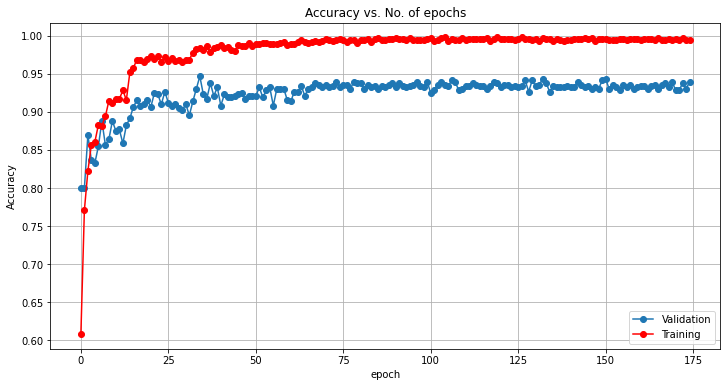

In [7]:
plot_parameters_with_epochs(history_df,"Accuracy")

> Observations:
- The training Accuracy very high and the validation accuracy is stopped increasing after 75 epochs. 
- This shows that our model classification head is overfitted but it is generalized enough to give a avg validation of 93%. 

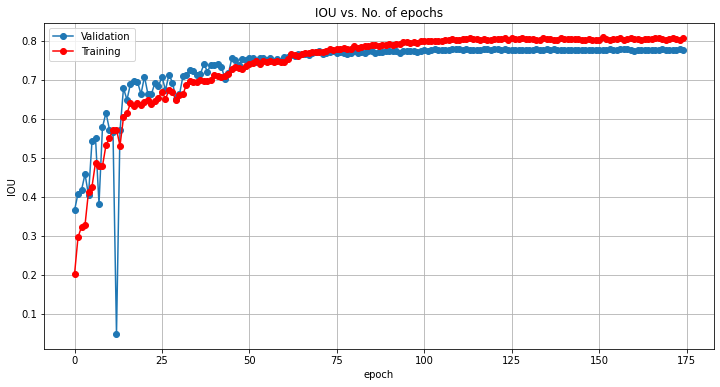

In [8]:
plot_parameters_with_epochs(history_df,"IOU")

> Observations:
- The training and validation IOU is constant after 75 epochs,this shows that our bounding box head need more information to predict the bbox positon more accurately.  

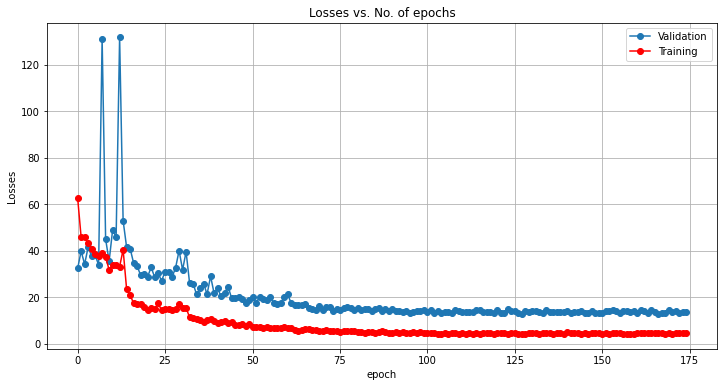

In [9]:
plot_parameters_with_epochs(history_df,"Losses")



> Observations:
- The loss after 100 epochs is mostly constant this could be because the model is learning very slowly.
- The overfitting in this case can be controlled by adding more regularization to the classification head and using different Bounding box Regressor.




### Evaluation

In [ ]:
def evaluate(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              device: torch.device):
    # Put model in eval mode
    model.to(device)
    model.eval() 

    # Setup metric values
    test_acc, test_iou = 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
            # Send data to target device
            (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # Forward pass
            y_label_pred,y_bbox_pred = model(X)

            # Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            test_iou += intersection_over_union(y_bbox_pred,y_bbox,'corners').sum().item()/len(y_bbox_pred)

    # Avg metrics 
    test_acc = test_acc / len(dataloader)
    test_iou = test_iou/ len(dataloader)
    return test_acc, test_iou

- Our model has performed well on the test set. Let's see some sample predictions in action.

### Show batch of images

In [ ]:
def show_random_batch(model,dataloader):
  device=get_device()

  def show_batch(model,batch):
    model.eval()
    with torch.inference_mode():
      (X,y_label, y_bbox) = batch
      batch_size = X.shape[0]
      assert batch_size == 8, f"Expecting batch size of 8, given batch size -> {batch_size}"

      (X,y_label, y_bbox) = X.to(device),y_label.to(device),y_bbox.to(device)
      y_label_pred,y_bbox_pred = model(X)
      y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
      batch_iou = intersection_over_union(y_bbox_pred,y_bbox,'corners').cpu()

      fig,axes = plt.subplots(4, 2, figsize=(12,24))
      axes = [ax for sub_ax in axes for ax in sub_ax]
      y_bbox,y_bbox_pred = y_bbox.cpu(),y_bbox_pred.cpu()
      y_label,y_pred_class = y_label.cpu(),y_pred_class.cpu() 
      for idx,ax in enumerate(axes):
        ## image
        img = denormalize(X[idx]).squeeze(axis=0).permute(1,2,0).cpu()
        ax.imshow(img)

        ## Ground Truth Bounding box
        xmin   = y_bbox[idx][0].numpy().astype(np.uint8)
        ymin   = y_bbox[idx][1].numpy().astype(np.uint8)
        width  = (y_bbox[idx][2]-y_bbox[idx][0]).numpy().astype(np.uint8)
        height = (y_bbox[idx][3]-y_bbox[idx][1]).numpy().astype(np.uint8)
        rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor='g',facecolor='none')
        ax.add_patch(rect)

        ## Predicted Bounding box 
        xmin   = y_bbox_pred[idx][0].numpy().astype(np.uint8)
        ymin   = y_bbox_pred[idx][1].numpy().astype(np.uint8)
        width  = (y_bbox_pred[idx][2]-y_bbox_pred[idx][0]).numpy().astype(np.uint8)
        height = (y_bbox_pred[idx][3]-y_bbox_pred[idx][1]).numpy().astype(np.uint8)
        rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ## adding info
        breed_orig = class_to_idx["class_label"][y_label[idx].item()]
        species_orig = class_to_idx["species_label"][y_label[idx].item()]
        breed_pred = class_to_idx["class_label"][y_pred_class[idx].item()]
        species_pred = class_to_idx["species_label"][y_pred_class[idx].item()]
        iou = batch_iou[idx].item()

        ax.set_title(f"""
        Label : {breed_orig.upper()} | Predicted : {breed_pred.upper()} 
        Species : {species_orig.upper()}
        IOU : {iou:.2f}""")
        ax.set_axis_off()

  batch_no = random.randint(0,len(dataloader)-1)
  for batch_id,batch in enumerate(dataloader):
    if batch_id == batch_no:
      show_batch(model,batch)

In [ ]:
test_transforms = A.Compose(
    [A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)
seed_everything(SEED)
test_data = oxfordDataset(test_df,test_transforms)
test_dataloader = DataLoader(dataset=test_data, batch_size=8)

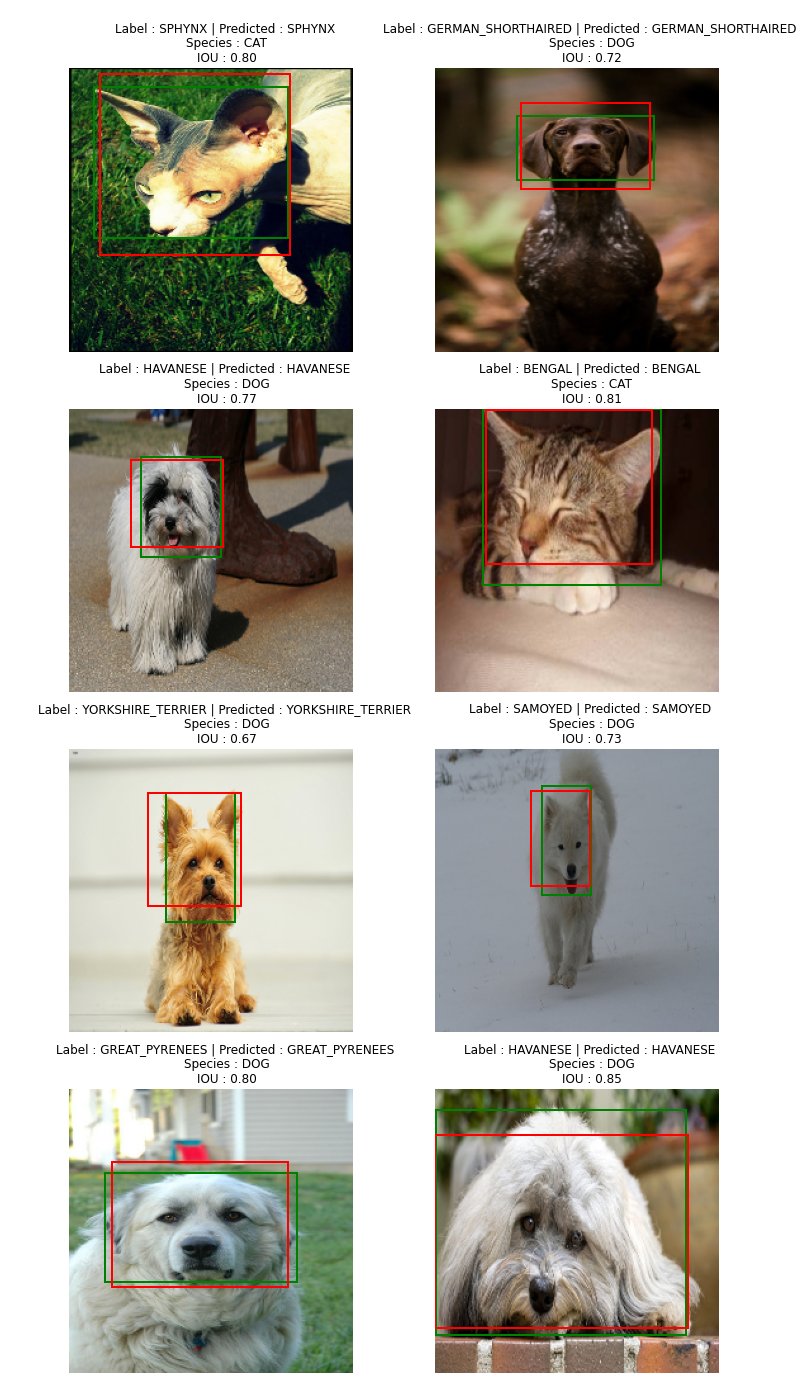

In [ ]:
show_random_batch(model,test_dataloader)

## Custom Image Prediction

- The below cell blocks will contain all the code required to classify and localize a custom image from a image path

In [ ]:
import os
import random
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [ ]:
## DIR_CONFIGS
IMAGE_DIR = os.path.join(os.getcwd(),"images")
MODEL_DIR = os.path.join(os.getcwd(),"model")

os.mkdir(IMAGE_DIR)
os.mkdir(MODEL_DIR)

## DATA CONFIGS
IMG_SIZE = 224
IMAGE_CHANNELS = 3
NUM_CLASSES = 37
BOUNDING_BOX_POINTS = 4
RESNET_LAYERS = 50
SEED = 42
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225] 

In [ ]:
# Helper Functions
def seed_everything(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED  
    """
    random.seed(TORCH_SEED)  
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

In [ ]:
## LocNet Model with Resnet backbone with pretrained
class LocNet(nn.Module):
    def __init__(self,num_layers,image_channels,num_classes,bb_points,pretrained):
        super(LocNet,self).__init__()
        self.num_layers = num_layers
        self.image_channels = image_channels
        self.num_classes = num_classes
        self.bb_points = bb_points
        self.backbone= self.get_backbone(pretrained)
        self.in_features = 512 if num_layers < 50 else 2048

        self.fc_classification = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        )

        self.fc_bounding_box = nn.Sequential(
            nn.Conv2d(in_channels=self.in_features,out_channels=2048,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.Conv2d(in_channels=2048,out_channels=2048,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=2048,out_channels=1024,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=1024,out_channels=self.in_features,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=self.in_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=bb_points)
        )
    def forward(self,x):
        x = self.backbone(x)
        y_classification = self.fc_classification(x)
        y_bounding_box = self.fc_bounding_box(x)
        return y_classification,y_bounding_box
    
    def get_backbone(self,pretrained):
        if pretrained:
            weights,model = self.get_model_details(self.num_layers)
            pretrained_model = model(weights=weights.DEFAULT)
            for param in pretrained_model.parameters():
                param.requires_grad = False 
            layers = list(pretrained_model.children())[:8]
            backbone = nn.Sequential(*layers)
            return backbone
        else:
            pass
            # backbone =  self.custom_resnet(num_layers=self.num_layers,
            #                           block=ResidualBlock,
            #                           image_channels=self.image_channels,
            #                           num_classes=self.num_classes)
            # for c in backbone.children():
            #     if isinstance(c, nn.Conv2d):
            #         nn.init.xavier_uniform_(c.weight)
            # return backbone
        
    def get_model_details(self,num_layers):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        resnet_models = {
            18 : [torchvision.models.ResNet18_Weights,torchvision.models.resnet18],
            34 : [torchvision.models.ResNet34_Weights,torchvision.models.resnet34],
            50 : [torchvision.models.ResNet50_Weights,torchvision.models.resnet50],
            101: [torchvision.models.ResNet101_Weights,torchvision.models.resnet101],
            152: [torchvision.models.ResNet152_Weights,torchvision.models.resnet152]
        }
        return resnet_models[num_layers]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load saved model 
seed_everything(SEED)
model = LocNet(num_layers=RESNET_LAYERS,
               image_channels=IMAGE_CHANNELS,
               num_classes=NUM_CLASSES,
               bb_points=BOUNDING_BOX_POINTS,
               pretrained=True).to(get_device())
model.load_state_dict(torch.load('/content/drive/MyDrive/models/7779.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
resize_transform = transforms.Resize(IMG_SIZE)
target_image = torchvision.io.read_image(str(os.path.join(IMAGE_DIR,"Abyssinian_201.jpg"))).type(torch.float32)

In [ ]:
test_transforms = A.Compose(
    [A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

In [ ]:
target_image = torchvision.io.read_image(str(os.path.join(IMAGE_DIR,"Abyssinian_201.jpg"))).type(torch.float32)

In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
import os
import random
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [ ]:
## DIR_CONFIGS
IMAGE_DIR = os.path.join(os.getcwd(),"images")
MODEL_DIR = os.path.join(os.getcwd(),"model")

os.mkdir(IMAGE_DIR)
os.mkdir(MODEL_DIR)

## DATA CONFIGS
IMG_SIZE = 224
IMAGE_CHANNELS = 3
NUM_CLASSES = 37
BOUNDING_BOX_POINTS = 4
RESNET_LAYERS = 50
SEED = 42
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225] 

In [ ]:
# Helper Functions
def seed_everything(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED  
    """
    random.seed(TORCH_SEED)  
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

def denormalize(images, means=IMAGENET_MEAN, stds=IMAGENET_STD,device=get_device()):
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)

In [ ]:
## LocNet Model with Resnet backbone with pretrained
class LocNet(nn.Module):
    def __init__(self,num_layers,image_channels,num_classes,bb_points,pretrained):
        super(LocNet,self).__init__()
        self.num_layers = num_layers
        self.image_channels = image_channels
        self.num_classes = num_classes
        self.bb_points = bb_points
        self.backbone= self.get_backbone(pretrained)
        self.in_features = 512 if num_layers < 50 else 2048

        self.fc_classification = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        )

        self.fc_bounding_box = nn.Sequential(
            nn.Conv2d(in_channels=self.in_features,out_channels=2048,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.Conv2d(in_channels=2048,out_channels=2048,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=2048,out_channels=1024,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=1024,out_channels=self.in_features,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=self.in_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=bb_points)
        )
    def forward(self,x):
        x = self.backbone(x)
        y_classification = self.fc_classification(x)
        y_bounding_box = self.fc_bounding_box(x)
        return y_classification,y_bounding_box
    
    def get_backbone(self,pretrained):
        if pretrained:
            weights,model = self.get_model_details(self.num_layers)
            pretrained_model = model(weights=weights.DEFAULT)
            for param in pretrained_model.parameters():
                param.requires_grad = False 
            layers = list(pretrained_model.children())[:8]
            backbone = nn.Sequential(*layers)
            return backbone
        else:
            pass
            # backbone =  self.custom_resnet(num_layers=self.num_layers,
            #                           block=ResidualBlock,
            #                           image_channels=self.image_channels,
            #                           num_classes=self.num_classes)
            # for c in backbone.children():
            #     if isinstance(c, nn.Conv2d):
            #         nn.init.xavier_uniform_(c.weight)
            # return backbone
        
    def get_model_details(self,num_layers):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        resnet_models = {
            18 : [torchvision.models.ResNet18_Weights,torchvision.models.resnet18],
            34 : [torchvision.models.ResNet34_Weights,torchvision.models.resnet34],
            50 : [torchvision.models.ResNet50_Weights,torchvision.models.resnet50],
            101: [torchvision.models.ResNet101_Weights,torchvision.models.resnet101],
            152: [torchvision.models.ResNet152_Weights,torchvision.models.resnet152]
        }
        return resnet_models[num_layers]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Load saved model 
seed_everything(SEED)
model = LocNet(num_layers=RESNET_LAYERS,
               image_channels=IMAGE_CHANNELS,
               num_classes=NUM_CLASSES,
               bb_points=BOUNDING_BOX_POINTS,
               pretrained=True).to(get_device())
model.load_state_dict(torch.load('/content/drive/MyDrive/models/7779.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
test_transforms = A.Compose(
    [
        A.Resize(256,256),
        A.CenterCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, max_pixel_value=255,),
        ToTensorV2(),
    ])

In [ ]:
resize_transform = transforms.Compose([
                          transforms.Resize(256),
                          transforms.CenterCrop(IMG_SIZE)])
target_transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(IMAGENET_MEAN,IMAGENET_STD)
                          ])

In [ ]:
# test_transforms = transforms.Compose([
#                     transforms.Resize(256),
#                     transforms.CenterCrop(IMG_SIZE),
#                     transforms.ToTensor(),
#                     transforms.Normalize(
#                         IMAGENET_MEAN,
#                         IMAGENET_STD)])

In [ ]:
from PIL import Image
  
target_obj = Image.open(str(os.path.join("/content/data/oxford-iiit-pet/images","test_image.jpg")),mode="r")
# target_image = target_transform(resize_transform(target_obj))
target_image = test_transforms(image=np.array(target_obj))
target_image = target_image["image"]

In [ ]:
model.to(get_device())
model.eval()
with torch.inference_mode():
    # Add an extra dimension to the image
  target_image = target_image.unsqueeze(dim=0)

  # Make a prediction on image with an extra dimension and send it to the target device
  y_class_pred,y_bbox_preds = model(target_image.to(get_device()))

In [ ]:
class_to_idx["class_label"][torch.argmax(y_class_pred,dim=1).item()]

'abyssinian'

In [ ]:
torch.max(torch.softmax(y_class_pred,dim=1),dim=1)

torch.return_types.max(
values=tensor([1.]),
indices=tensor([0]))

In [ ]:
for val in y_bbox_preds[0]:
    print(val.numpy().astype(np.uint8))

11
0
177
156


In [ ]:
for val in y_bbox_preds[0]:
    print(val.numpy().astype(np.uint8))

11
0
177
156


11 0 166 156


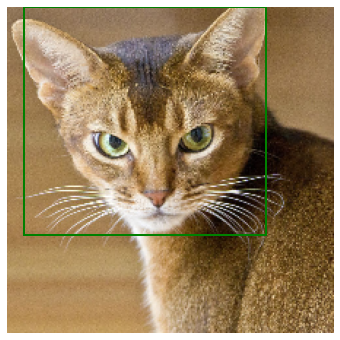

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
img = denormalize(target_image).squeeze(axis=0).permute(1,2,0).cpu()
ax.imshow(img)
idx=0
## Ground Truth Bounding box
xmin   = y_bbox_preds[idx][0].numpy().astype(np.uint8)
ymin   = y_bbox_preds[idx][1].numpy().astype(np.uint8)
width  = (y_bbox_preds[idx][2]-y_bbox_preds[idx][0]).numpy().astype(np.uint8)
height = (y_bbox_preds[idx][3]-y_bbox_preds[idx][1]).numpy().astype(np.uint8)
print(xmin,ymin,width,height)
rect = patches.Rectangle((xmin,ymin),width,height,linewidth=2,edgecolor='g',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()